Potential resource(s):
http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

# Mental Health in Tech Project

## Data Sets

[OSMI Survey on Mental Health in the Tech Workplace in 2014](https://www.kaggle.com/osmi/mental-health-in-tech-survey) 

["Ongoing" OSMI survey from 2016](https://data.world/kittybot/osmi-mental-health-tech-2016)


## Questions

What factors are most signficant in influencing whether or not a person believes disclosing a mental health issue would have negative consequences?

Can we predict, based on publicly available features of a person and company, whether that person is likely to beleive disclosing a mental health issue would be harmful for their career?

## Plan

In [1]:
# clean 2014 data:
#   - remove invalid ages  ( < 16, > 80)
#   - create gender categories
#   - create dictionary to map questions to column names (from original data set)
#   - add year column with all 2014s

In [2]:
# use only US data

In [3]:
# plot number of responses by age

In [4]:
# plot frequency of mental health consequences yes/no/maybe by age

In [5]:
# plot frequency of mental health consequence yes/no/maybe by age groups (quantiles, 4-6 groups)

In [6]:
################ Logistic Regression

In [7]:
# logistic regression 
# - combine mental health consequences (yes and maybe) vs no as boolean categorical Y to predict
# - pull out X variables that are public
# - created dummies for categorical public X variables

## Setup

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Import & Initial Data Cleaning

In [9]:
df14 = pd.read_csv('./datasets/2014/clean-no-dummies-2014.csv', index_col=0)
print df14.shape

(1259, 28)


### Limit to US Data

In [10]:
df14 = df14[df14['country']=='United States']
print df14.shape
df14.head(3)

(751, 28)


,timestamp,age,gender,country,state,self_employed,family_history,treatment,work_interfere,num_employees,...,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments,gender_category
0,2014-08-27 11:29:31,37.0,Female,United States,IL,NaN,no,1,often,6-25,...,no,no,some_of_them,yes,no,maybe,yes,0,NaN,female
1,2014-08-27 11:29:37,44.0,M,United States,IN,NaN,no,0,rarely,1000+,...,maybe,no,no,no,no,no,dont_know,0,NaN,male
4,2014-08-27 11:30:22,31.0,Male,United States,TX,NaN,no,0,never,100-500,...,no,no,some_of_them,yes,yes,yes,dont_know,0,NaN,male


### Column-Question Mapping

Conveniently look up the survey question associated with each column name.

Can also add to the maps to describe created columns.

In [11]:
# map column names to questions
df14.cq = {'age': 'Age',
 'anonymity': 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources?',
 'benefits': 'Does your employer provide mental health benefits?',
 'care_options': 'Do you know the options for mental health care your employer provides?',
 'country': 'Country',
 'coworkers': 'Would you be willing to discuss a mental health issue with your coworkers?',
 'family_history': 'Do you have a family history of mental illness?',
 'gender': 'Gender',
 'leave': 'How easy is it for you to take medical leave for a mental health condition?',
 'mental_health_consequence': 'Do you think that discussing a mental health issue with your employer would have negative consequences?',
 'mental_health_interview': 'Would you bring up a mental health issue with a potential employer in an interview?',
 'mental_vs_physical': 'Do you feel that your employer takes mental health as seriously as physical health?',
 'num_employees': 'How many employees does your company or organization have?',
 'obs_consequence': 'Have you heard of or observed negative consequences for coworkers with mental health conditions in your workplace?',
 'phys_health_consequence': 'Do you think that discussing a physical health issue with your employer would have negative consequences?',
 'phys_health_interview': 'Would you bring up a physical health issue with a potential employer in an interview?',
 'remote_work': 'Do you work remotely (outside of an office) at least 50% of the time?',
 'seek_help': 'Does your employer provide resources to learn more about mental health issues and how to seek help?',
 'self_employed': 'Are you self-employed?',
 'state': 'If you live in the United States, which state or territory do you live in?',
 'supervisor': 'Would you be willing to discuss a mental health issue with your direct supervisor(s)?',
 'tech_company': 'Is your employer primarily a tech company/organization?',
 'timestamp': 'Timestamp',
 'treatment': 'Have you sought treatment for a mental health condition?',
 'wellness_program': 'Has your employer ever discussed mental health as part of an employee wellness program?',
 'work_interfere': 'If you have a mental health condition, do you feel that it interferes with your work?'
}

#### Additional Derived Columns

In [12]:
# gender_category_explanation = 'Derived column: categorized gender responses into male/female/other. Trans males and females are categorized as males and females, respectively.'
# df14.cq['gender_category'] = gender_category_explanation
df14.cq['gender_category'] = 'Derived: male/female/other. Trans male and trans female categorized as male and female, respectively.'

In [13]:
df14['year'] = 2014

#### Preview Column Function

In [14]:
# helper function to get column preview
def preview_col(col, data=df14):
    if col in data.cq:
        print data.cq[col]
    print data[col].value_counts(dropna=False)

In [15]:
preview_col('treatment')


Have you sought treatment for a mental health condition?
1    410
0    341
Name: treatment, dtype: int64


### Mental Health Consequences Boolean Column

Adding a column that will have 1 if the respondent answered `yes` or `maybe` for mental health consequence, and 0 if `no`.

In [16]:
mhc = 'mental_health_consequence'
preview_col(mhc)

Do you think that discussing a mental health issue with your employer would have negative consequences?
maybe    300
no       280
yes      171
Name: mental_health_consequence, dtype: int64


In [17]:
mhc2 = 'mental_health_yes_maybe'

In [18]:
def ymn(ynmstr):
    if ynmstr == 'no':
        return 0
    else:
        return 1
df14['mental_health_yes_maybe'] = df14['mental_health_consequence'].map(lambda(x): ymn(x))

In [19]:
df14[mhc2].sum()

471

In [20]:
df14[mhc].value_counts()

maybe    300
no       280
yes      171
Name: mental_health_consequence, dtype: int64

### Responses by age

In [21]:
df16.groupby('age').size().plot(kind='bar')

NameError: name 'df16' is not defined

In [ ]:
df14.age.describe()

In [ ]:
gcs = df14.groupby('gender_category')
gcs.size()

In [ ]:
gcs.groups

In [ ]:
gcs.size()['female']

In [ ]:
df14['gender_category'].unique()

In [ ]:
def plot_percentages(df, category_col, target_col):
    for cat_val in df[category_col].unique():
        get_percentages_val(df, category_col, target_col, cat_val)
        
        
def get_percentages_val(df, category_col, target_col, cat_val):
    catdf = df[df[category_col]==cat_val]
    num_this_catval = catdf.shape[0]
    cat_target_groups = catdf.groupby(target_col)
    cat_target_sizes = cat_target_groups.size()
    print cat_target_sizes
    cat_target_percentages =  100 * cat_target_sizes / num_this_catval
    return cat_target_percentages
    
mp = get_percentages_val(df14, 'gender_category', mhc, 'male')
fp = get_percentages_val(df14, 'gender_category', mhc, 'female')
op = get_percentages_val(df14, 'gender_category', mhc, 'other')
op['no'] = 0.0
print mp 
print fp 
print op

In [ ]:
fig = plt.figure()

mp.plot(kind='bar', color='red', position=2, width=0.1)
fp.plot(kind='bar', color='blue', position=1, width=0.1)
op.plot(kind='bar', color='green', position=0, width=0.1, opacity=0.5)
fig.set_ylabel = ('percent')
plt.show()

In [ ]:
fdf14 = df14[df14['gender_category']=='female']
nf = fdf14.shape[0]
print nf
fdf14.head(2)

In [ ]:
fmhc = fdf14.groupby(mhc)

In [ ]:
fmhc.size()

In [ ]:
fmhcp = 100 * fmhc.size() / nf

In [ ]:
fmhcp.plot(kind='bar')

In [ ]:
def cat_proportion_in_col(df, main, sub):
    d = df[[main, sub]].copy()
    count_subs_per_main = d.groupby([main, sub]).size()
    percent_subs_per_main = count_subs_per_main.groupby(level=[0]).apply(lambda x: 100*x /  x.sum())
    return percent_subs_per_main

pros = cat_proportion_in_col(df14, 'gender_category', mhc)
print 'no' in pros['other']
pros[('other', 'no')] = 0 
pros

In [ ]:
# pros

In [ ]:
# sns.swarmplot(x=, data=pros)

In [ ]:
sns.swarmplot(y=mhc, x='age', data=df14)

In [ ]:
sns.violinplot(
    x='treatment', 
    y='age', 
    hue=mhc, 
    data=df14,         
    split=False, 
#     inner="stick", 
    palette="Set2"
);

In [ ]:
fg = seaborn.factorplot(x='Group', y='val(continuous)', hue='Mean', 
                        col='Sex', row='', data=data, kind='bar')
fg.set_xlabels('')

In [ ]:
pdf = pd.DataFrame(pros)
pdf

In [ ]:
pdf.reset_index(inplace=True)
pdf

In [ ]:
pdf.rename(columns={0: 'percentage'}, inplace=True)

In [ ]:
fg = sns.factorplot(
    x=mhc, 
    y='percentage',
    col='gender_category',
    data=pdf, 
    kind='bar',
    palette='Set1',
    order=['no', 'maybe', 'yes']
)
# fg.set_xlabels('')

In [ ]:
r = df14[df14['age']>25]
r = r[r['age']<50]
agep = cat_proportion_in_col(r,'age', mhc)
agep.head(8)

In [ ]:
colors = {'no': 'r', 'maybe': 'b', 'yes': 'g'}
ax = agep.plot(
    kind='bar', 
#     kind='scatter',
    x='age', 
#     xlim=80,
    y='percentage',
    color=[colors[cat] for cat in ['no', 'yes', 'maybe']]
)
# new_ticks = np.linspace(agep.age.min(), agep.age.max(), 4)
# positions of each tick, relative to the indices of the x-values
# ax.set_xticks(np.interp(new_ticks, agep.age, np.arange(agep.shape[0])))

# labels
# ax.set_xticklabels(new_ticks)

In [23]:
def cat_proportion_in_col(df, main, sub):
    d = df[[main, sub]].copy()
    count_subs_per_main = d.groupby([main, sub]).size()
    percent_subs_per_main = count_subs_per_main.groupby(level=[0]).apply(lambda x: 100*x /  x.sum())
    pdf = pd.DataFrame(percent_subs_per_main)
    pdf.reset_index(inplace=True)
    pdf.rename(columns={0:'percentage'}, inplace=True)
    return pdf

pros = cat_proportion_in_col(df14, 'treatment', mhc)
pros

,treatment,mental_health_consequence,percentage
0,0,maybe,37.536657
1,0,no,45.161290
2,0,yes,17.302053
3,1,maybe,41.951220
4,1,no,30.731707
5,1,yes,27.317073


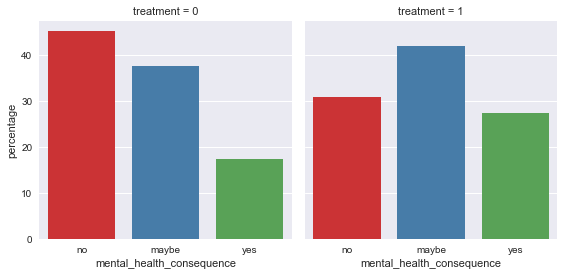

In [24]:
fg = sns.factorplot(
    x=mhc, 
    y='percentage',
    col='treatment',
    data=pros, 
    kind='bar',
    palette='Set1',
    order=['no', 'maybe', 'yes']
)
# fg.set_xlabels('')

In [30]:
def plot_percentage(df, main_col, sub_col):
    percent_df = cat_proportion_in_col(df, main_col, sub_col)
    fg = sns.factorplot(
        x=mhc, 
        y='percentage',
        col=main_col,
        data=percent_df, 
        kind='bar',
        palette='Set1',
        order=['no', 'maybe', 'yes']
    )

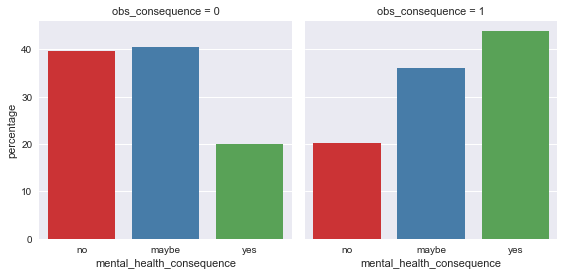

In [31]:
plot_percentage(df14, 'obs_consequence', mhc)

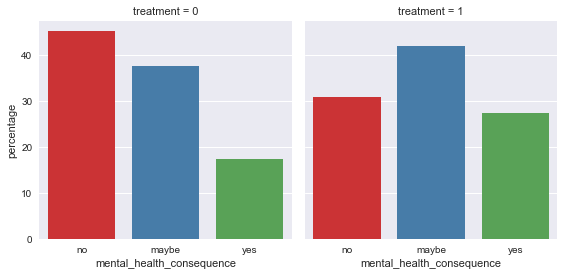

In [32]:
plot_percentage(df14, 'treatment', mhc)

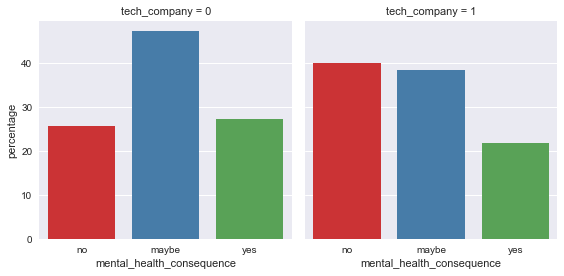

In [33]:
plot_percentage(df14, 'tech_company', mhc)

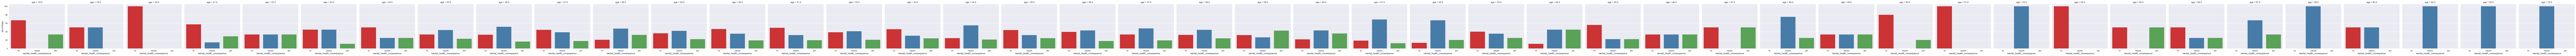

In [34]:
plot_percentage(df14, 'age', mhc)